In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from pydataxm import *                           #Se realiza la importación de las librerias necesarias para ejecutar                        
from pydataxm.pydataxm import ReadDB as apiXM 
import datetime as dt                            
import pandas as pd
from pathlib import Path
import os

from google.cloud import bigquery
from google.oauth2 import service_account

In [2]:
FechaIni=dt.date(2020, 1,1)
# FechaFin=dt.date(2020, 3,31)
FechaFin=dt.date(2025, 11, 30)
sFechaFin = FechaFin.strftime('%Y-%m-%d')
dias_mes = (FechaFin - FechaIni).days + 1

In [3]:
df_RecIni= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "ListadoRecursos",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Sistema",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_RecIni['Values_Code']=df_RecIni['Values_Code'].astype(str)

# Units kWh, Descarga de la disponibilidad real
df_DispDecIni= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "DispoDeclarada",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta

# Units kWh, Descarga de la disponibilidad real
df_GenRealIni= apiXM.request_data(pydataxm.ReadDB(),    #Se indica el objeto que contiene el serivicio
                        "Gene",                #Se indica el nombre de la métrica tal como se llama en el campo metricID
                        "Recurso",                 #Campo que indica si es Sistema, Agente, Recurso, Comercializador
                        FechaIni,       #Corresponde a la fecha inicial de la consulta
                        FechaFin)      #Corresponde a la fecha final de la consulta
df_GenRealIni['Values_code']=df_GenRealIni['Values_code'].astype(str)

In [7]:
df_Rec=df_RecIni.copy()
df_Disp=df_DispDecIni.copy()
df_GReal=df_GenRealIni.copy()

if 'Date' in df_Rec.columns:
    df_Rec=df_Rec.drop('Date',axis=1)

df_GReal=df_GReal.fillna(0)
df_Rec=df_Rec.fillna(0)
l_per=[]
for i in range(1,25):
    if i<10:
        df_GReal=df_GReal.rename(columns={'Values_Hour0' + str(i) : str(i) })
        df_Disp=df_Disp.rename(columns={'Values_Hour0' + str(i) : str(i) })
    else:
        df_GReal=df_GReal.rename(columns={'Values_Hour' + str(i) : str(i) })
        df_Disp=df_Disp.rename(columns={'Values_Hour' + str(i) : str(i) })

    df_GReal[str(i)]=df_GReal[str(i)]/1000
    df_Disp[str(i)]=df_Disp[str(i)]/1000
    l_per.append(str(i))

# Converti columnas de periodos en una sola columna
df_Disp = df_Disp.melt(id_vars=['Values_code', 'Date'], value_vars=l_per,var_name='periodo',value_name='Disp')
df_Disp['periodo'] = df_Disp['periodo'].astype(int)

df_GReal = df_GReal.melt(id_vars=['Values_code', 'Date'], value_vars=l_per,var_name='periodo',value_name='Gen')
df_GReal['periodo'] = df_GReal['periodo'].astype(int)

df_Disp=df_Disp[(df_Disp['Values_code'].isin(['TBQ3','TBQ4']))]
df_GReal=df_GReal[(df_GReal['Values_code'].isin(['TBQ3','TBQ4']))]

df_data=df_Disp.merge(df_GReal,left_on=['Values_code','Date','periodo'],right_on=['Values_code','Date','periodo'],how='left')[['Date','Values_code','periodo','Disp','Gen']]
df_data['Gen']=df_data['Gen'].fillna(0)



In [8]:
# Partimos de df_data con columnas:
# ['Date', 'Values_code', 'periodo', 'Disp', 'Gen']

# 1) Asegurar tipos correctos
df_data = df_data.copy()
df_data['Date'] = pd.to_datetime(df_data['Date'])
df_data['periodo'] = df_data['periodo'].astype(int)

df_data.to_csv('DataBquilla.csv')

# EXCLUIR periodos donde la disponibilidad es cero
df_data = df_data[df_data['Disp'] > 0].copy()

# 2) Calcular si en cada periodo la planta genera al menos el 95% de la disponibilidad
#    Si Disp es 0, la condición Gen >= 0.95 * Disp se cumple automáticamente si Gen también es 0
df_data['cumple_95'] = df_data['Gen'] >= 0.95 * df_data['Disp']

# 3) Agregar por día y planta:
#    - all_24_ok: True si TODOS los periodos de ese día cumplen la condición
#    - n_periodos: número de periodos observados ese día (para control)
agg_diaria = (
    df_data
    .groupby(['Values_code', 'Date'], as_index=False)
    .agg(
        all_24_ok=('cumple_95', 'all'),
        n_periodos=('cumple_95', 'size')
    )
)

# EXCLUIR días donde no quedó ningún periodo evaluable (>0 disponibilidad)
agg_diaria = agg_diaria[agg_diaria['n_periodos'] > 0].copy()

# 4) Filtrar solo días que tienen TODOS los periodos >= 95% de la disponibilidad
agg_diaria_ok = agg_diaria[agg_diaria['all_24_ok']]

# 5) Contar número de días por planta
dias_por_planta = (
    agg_diaria_ok
    .groupby('Values_code')['Date']
    .nunique()
    .rename('num_dias_24p_ge_95pct')
    .reset_index()
)

print("Número de días con los 24 periodos >= 95% de la disponibilidad por planta:")
print(dias_por_planta)

# 6) (Opcional) Ver también el detalle de las fechas por planta
# por si quieres revisar o usar esas fechas en otro análisis

fechas_por_planta = (
    agg_diaria_ok
    .sort_values(['Values_code', 'Date'])
    .loc[:, ['Values_code', 'Date']]
)




Número de días con los 24 periodos >= 95% de la disponibilidad por planta:
  Values_code  num_dias_24p_ge_95pct
0        TBQ3                     49
1        TBQ4                     68


### 1) PROBABILIDAD ANUAL por planta de cumplir ≥95 %

In [12]:
# -------------------------------
# PROBABILIDAD ANUAL POR PLANTA
# -------------------------------

prob_anual = (
    agg_diaria
    .assign(year=lambda x: x['Date'].dt.year)
    .groupby(['Values_code', 'year'])['all_24_ok']
    .mean()
    .rename('prob_ge_95pct')
    .reset_index()
)

print("Probabilidad anual de cumplir >=95% en los 24 periodos:")
print(prob_anual)

prob_anual.to_csv('DatosBaranquilla.csv',index=False)


Probabilidad anual de cumplir >=95% en los 24 periodos:
   Values_code  year  prob_ge_95pct
0         TBQ3  2020       0.000000
1         TBQ3  2021       0.000000
2         TBQ3  2022       0.000000
3         TBQ3  2023       0.036697
4         TBQ3  2024       0.105114
5         TBQ3  2025       0.000000
6         TBQ4  2020       0.000000
7         TBQ4  2021       0.000000
8         TBQ4  2022       0.000000
9         TBQ4  2023       0.088319
10        TBQ4  2024       0.102493
11        TBQ4  2025       0.000000


### 2) GRÁFICA MES–AÑO DEL NÚMERO DE DÍAS QUE CUMPLEN ≥ 95 %

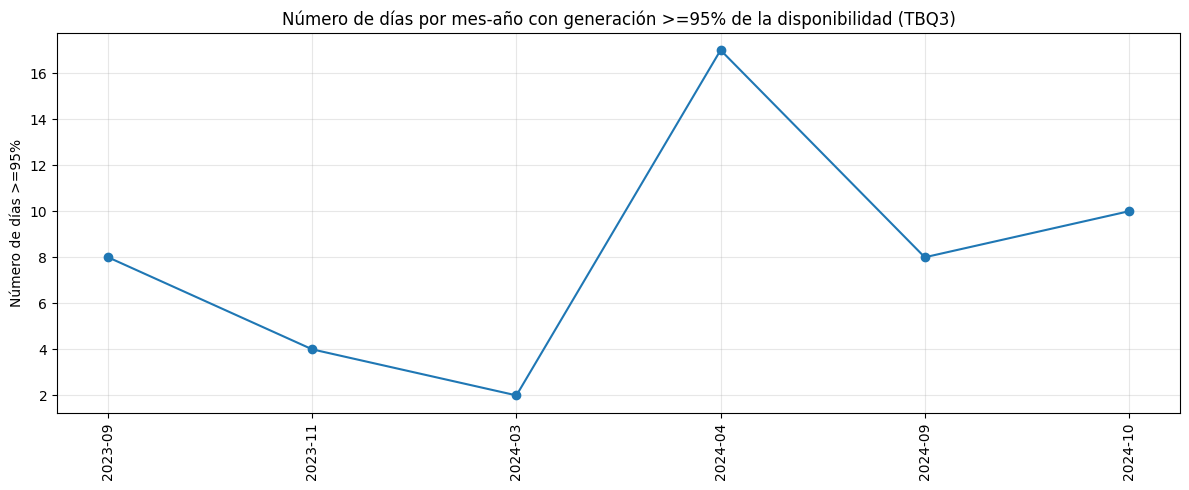

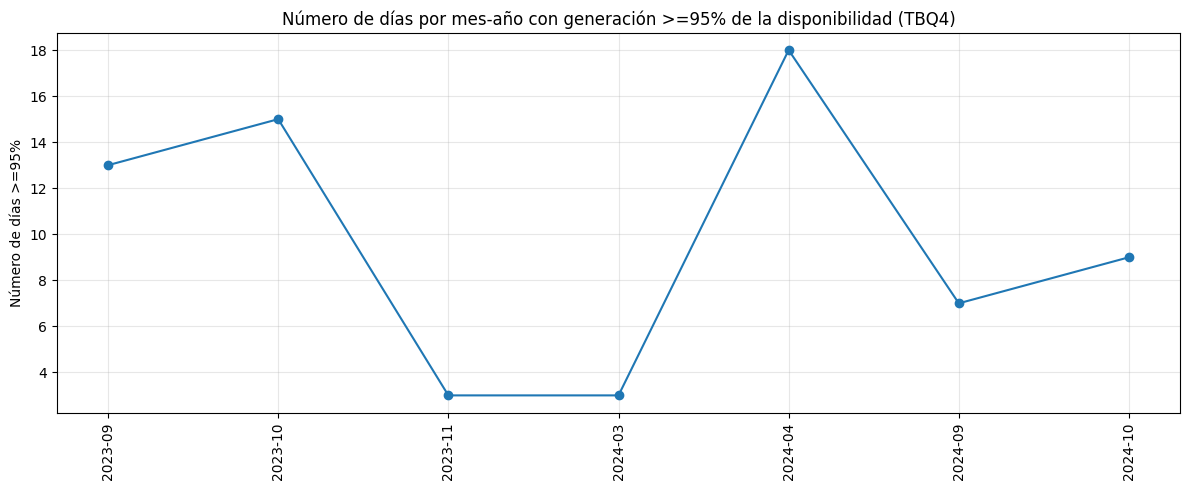

In [56]:
import matplotlib.pyplot as plt

# -------------------------------
# NUMERO DE DÍAS POR MES-AÑO
# -------------------------------
dias_mes = (
    agg_diaria[agg_diaria['all_24_ok']]
    .assign(year=lambda x: x['Date'].dt.year,
            month=lambda x: x['Date'].dt.month)
    .groupby(['Values_code', 'year', 'month'])['Date']
    .nunique()
    .rename('dias_ge_95pct')
    .reset_index()
)

# Gráfica
for planta in dias_mes['Values_code'].unique():
    dfp = dias_mes[dias_mes['Values_code'] == planta]

    plt.figure(figsize=(12,5))
    plt.plot(
        dfp['year'].astype(str) + '-' + dfp['month'].astype(str).str.zfill(2),
        dfp['dias_ge_95pct'],
        marker='o',
        label=f'{planta}'
    )
    plt.xticks(rotation=90)
    plt.ylabel("Número de días >=95%")
    plt.title(f"Número de días por mes-año con generación >=95% de la disponibilidad ({planta})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 3) GRÁFICA DE PROBABILIDAD ANUAL ≥95 %

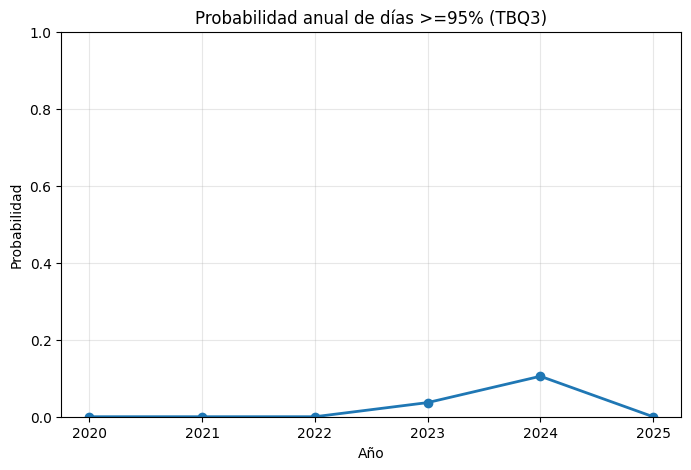

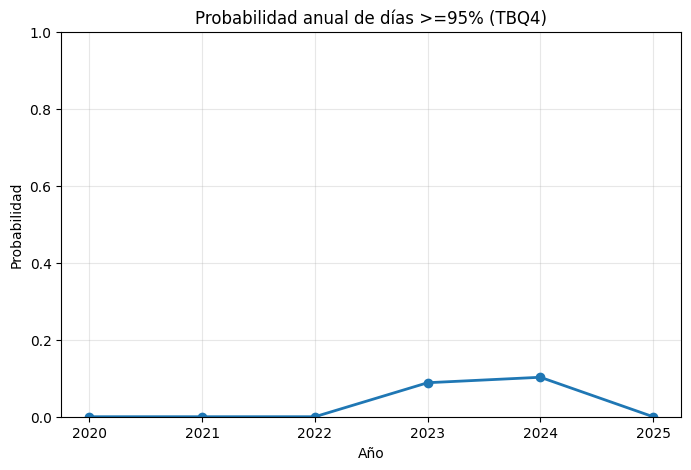

In [57]:
# -------------------------------
# GRAFICAR PROBABILIDAD ANUAL
# -------------------------------
for planta in prob_anual['Values_code'].unique():
    dfp = prob_anual[prob_anual['Values_code'] == planta]

    plt.figure(figsize=(8,5))
    plt.plot(dfp['year'], dfp['prob_ge_95pct'], marker='o', linewidth=2)
    plt.ylim(0,1)
    plt.title(f"Probabilidad anual de días >=95% ({planta})")
    plt.ylabel("Probabilidad")
    plt.xlabel("Año")
    plt.grid(True, alpha=0.3)
    plt.show()
